In [27]:
import pathlib

import astropy.table
import astropy.units as u
from astropy.visualization import quantity_support
import fiasco
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from synthesizAR.interfaces.ebtel import read_xml, run_ebtel

# DEM Constraints

In this notebook, I'm going to experiment with how different spectral lines allow for tighter constraints on the DEM distribution.

## 1. Compute model DEM distribution

In [2]:
EBTEL_DIR = pathlib.Path('/Users/wtbarnes/Documents/codes/ebtelPlusPlus/')

In [278]:
def multi_event_simulation(config, N, Heq, duration):
    tn = (config['total_time'] - N*duration)/N
    events = []
    for i in range(N):
        events.append({'event':{
            'rise_start': i*(tn + duration),
            'rise_end': i*(tn + duration) + duration/2,
            'decay_start': i*(tn + duration) + duration/2,
            'decay_end': i*(tn + duration) + duration,
            'magnitude': 2*config['total_time']*Heq/N/duration,}})

    config['heating']['events'] = events
    res = run_ebtel(config, EBTEL_DIR)
    res['time'] = u.Quantity(res['time'], 's')
    res['electron_temperature'] = u.Quantity(res['electron_temperature'], 'K')
    res['density'] = u.Quantity(res['density'], 'cm-3')
    if config['calculate_dem']:
        res['dem_temperature'] = res['dem_temperature']*u.K
        res['dem_corona'] = res['dem_corona']*u.cm**(-5)*u.K**(-1)
        res['dem_tr'] = res['dem_tr']*u.cm**(-5)*u.K**(-1)
        res['em_corona'] = res['dem_corona'] * np.gradient(res['dem_temperature'])
    return res

In [279]:
Heq = 2e-3
duration = 200.
L = 40 * u.Mm
config = read_xml(EBTEL_DIR / 'config' / 'ebtel.example.cfg.xml')
config['loop_length'] = L.to_value('cm')
config['calculate_dem'] = True
config['dem']['temperature'] = {
    'bins': 40,
    'log_min': 5.5,
    'log_max': 7.5,
}
res_single = multi_event_simulation(config, 1, Heq, duration)

In [365]:
res_single['em_corona'].mean(axis=0)

<Quantity [0.00000000e+00, 0.00000000e+00, 2.18265050e+25, 1.08209678e+26,
           1.66863217e+26, 1.99397621e+26, 2.59430738e+26, 3.42457640e+26,
           4.49628658e+26, 5.74305447e+26, 7.24898526e+26, 8.96080251e+26,
           1.09527181e+27, 1.35074282e+27, 1.77407079e+27, 2.43762559e+27,
           3.27920099e+27, 4.29310090e+27, 5.40273682e+27, 6.46626581e+27,
           7.20674871e+27, 7.22751301e+27, 6.53189386e+27, 5.39964278e+27,
           3.42678699e+27, 1.41519576e+27, 6.20490519e+26, 4.29890777e+26,
           4.17207910e+26, 4.76857321e+26, 3.27616115e+26, 2.13458015e+25,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00] 1 / cm5>

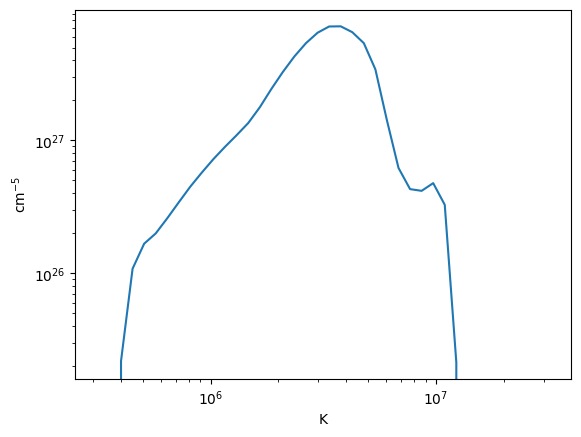

In [280]:
with quantity_support():
    plt.plot(res_single['dem_temperature'],
             np.mean(res_single['em_corona'], axis=0))
plt.yscale('log')
plt.xscale('log')

## 2. Compute Contribution Functions

Do this for all lines. We have two groupings of lines: cooler EIS-like lines and hotter "MOXSI" lines

In [6]:
line_list = astropy.table.QTable.read('/Users/wtbarnes/Documents/projects/cubixss/moxsi-science-planning/data/moxsi-line-list.asdf')

In [7]:
moxsi_wavelengths = [
    6.1803998947143555, # Si XIV
    6.647900104522705, # Si XIII
    14.668999671936035, # Fe XIX
    15.012999534606934, # Fe XVII
    17.051000595092773, # Fe XVII
    #17.09600067138672, # Fe XVII
    16.77560043334961, # Fe XVII
    16.07200050354004, # Fe XVII
    15.26200008392334, # Fe XVII
    12.82699966430664, # Fe XX
    18.967100143432617, # O VIII
    21.601499557495117, # O VII
    22.097700119018555, # O VII
    21.803600311279297, # O VII
    14.208800315856934, # Fe XVIII
    9.314299583435059, # Mg XI
    44.160301208496094, # Si XII
    13.524900436401367, # Fe XIX
    12.281999588012695, # Fe XXI
    #14.203900337219238, # Fe XVIII
] * u.AA

In [8]:
moxsi_lines = astropy.table.QTable(astropy.table.vstack([line_list[np.argmin(np.fabs(line_list['wavelength'] - w))] for w in moxsi_wavelengths]))
moxsi_lines = moxsi_lines[['ion name', 'element', 'wavelength']]

In [396]:
eis_lines['wavelength'] < 70 * u.Angstrom

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [9]:
moxsi_lines

ion name,element,wavelength
,,Angstrom
str9,str2,float64
Si XIV,Si,6.1803998947143555
Si XIII,Si,6.647900104522705
Fe XIX,Fe,14.668999671936035
Fe XVII,Fe,15.012999534606934
Fe XVII,Fe,17.051000595092773
Fe XVII,Fe,16.77560043334961
Fe XVIII,Fe,16.07200050354004
Fe XVII,Fe,15.26200008392334


In [10]:
# I manually transcribed these from Winebarger et al. (2012)
winebarger_lines = [
    ['Mg V', 276.579],
    ['Mg VI', 270.394],
    ['Fe IX', 188.497],
    ['Fe IX', 197.862],
    ['Mg VII', 280.737],
    ['Si VII', 275.368],
    ['Fe X', 184.536],
    ['Fe XI', 188.216],
    ['Fe XII', 192.394],
    ['Fe XI', 180.401],
    ['S X', 264.233],
    ['Si X', 258.375],
    ['Fe XII', 195.119],
    ['Fe XIII', 202.044],
    ['Fe XIII', 203.826],
    ['Fe XV', 284.160],
    ['Fe XIV', 270.519],
    ['Fe XIV', 264.787],
    ['Fe XVI', 262.984],
    ['S XIII', 256.686],
    ['Ca XIV', 193.874],
    ['Ca XV', 200.972],
    ['Ca XVI', 208.604],
    ['Ca XVII', 192.858],
]

In [11]:
eis_lines = astropy.table.QTable(
    data=[
        [iname for iname,_ in winebarger_lines],
        [wave for _,wave in winebarger_lines],
    ],
    names=['ion name', 'wavelength'],
    units={'wavelength': 'AA'},
)
eis_lines['element'] = list(map(lambda x: x.split()[0], eis_lines['ion name']))

In [12]:
eis_lines

ion name,wavelength,element
,Angstrom,
str7,float64,str2
Mg V,276.579,Mg
Mg VI,270.394,Mg
Fe IX,188.497,Fe
Fe IX,197.862,Fe
Mg VII,280.737,Mg
Si VII,275.368,Si
Fe X,184.536,Fe
Fe XI,188.216,Fe


In [13]:
temperature = 10**np.arange(5.5,7.5,0.01)*u.K
density = 1e15*u.Unit('K cm-3') / temperature
all_ions = list(moxsi_lines['ion name']) + list(eis_lines['ion name'])
ions = {iname: fiasco.Ion(iname, temperature) for iname in np.unique(all_ions)}
goft = {k: v.contribution_function(density, couple_density_to_temperature=True) for k,v in ions.items()}

Now add contribution functions to a column in the line tables

In [14]:
goft_col = []
for row in moxsi_lines:
    waves = ions[row['ion name']].transitions.wavelength[~ions[row['ion name']].transitions.is_twophoton]
    iwave = int(np.argmin(np.fabs(waves - row['wavelength'])))
    goft_col.append(goft[row['ion name']][..., iwave].squeeze())
moxsi_lines['contribution function'] = goft_col

In [15]:
goft_col = []
for row in eis_lines:
    waves = ions[row['ion name']].transitions.wavelength[~ions[row['ion name']].transitions.is_twophoton]
    iwave = int(np.argmin(np.fabs(waves - row['wavelength'])))
    goft_col.append(goft[row['ion name']][..., iwave].squeeze())
eis_lines['contribution function'] = goft_col

In [397]:
astropy.table.vstack([moxsi_lines, eis_lines]).write('/Users/wtbarnes/Desktop/line-list-test.asdf')

In [399]:
astropy.table.QTable.read('/Users/wtbarnes/Desktop/line-list-test.asdf')

ion name,element,wavelength,contribution function,intensity,intensity error
,,Angstrom,cm3 erg / s,erg / (s cm2),erg / (s cm2)
str9,str2,float64,float64[200],float64,float64
Si XIV,Si,6.1803998947143555,0.0 .. 3.05841598597021e-25,372.1333309385064,74.42666618770129
Si XIII,Si,6.647900104522705,0.0 .. 4.7037295158661345e-26,4480.511655043395,896.102331008679
Fe XIX,Fe,14.668999671936035,0.0 .. 9.377259789220135e-30,955.9230519409589,191.1846103881918
Fe XVII,Fe,15.012999534606934,0.0 .. 4.614349943523554e-31,157821.34369052295,31564.26873810459
Fe XVII,Fe,17.051000595092773,0.0 .. 1.7171808753933957e-31,135400.92103365686,27080.184206731374
Fe XVII,Fe,16.77560043334961,0.0 .. 1.41985446097862e-31,103150.6798087428,20630.13596174856
Fe XVIII,Fe,16.07200050354004,0.0 .. 1.1619747106506643e-30,13775.919407188034,2755.183881437607
Fe XVII,Fe,15.26200008392334,0.0 .. 1.2352770507341769e-31,45665.73031910451,9133.146063820901


In [407]:
eis_lines['temperature'] = [temperature,]

In [408]:
eis_lines

ion name,wavelength,element,contribution function,intensity,intensity error,temperature
,Angstrom,,cm3 erg / s,erg / (s cm2),erg / (s cm2),K
str7,float64,str2,float64[200],float64,float64,float64[200]
Mg V,276.579,Mg,2.0024310533082732e-24 .. 0.0,270.17811825493527,54.035623650987056,316227.7660168379 .. 30902954.325132888
Mg VI,270.394,Mg,6.457296288927791e-25 .. 4.277372555880386e-44,1174.9594936438198,234.99189872876397,316227.7660168379 .. 30902954.325132888
Fe IX,188.497,Fe,2.141747102532959e-32 .. 0.0,0.02396008955502285,0.00479201791100457,316227.7660168379 .. 30902954.325132888
Fe IX,197.862,Fe,1.5391564667722686e-32 .. 0.0,0.00895603892703333,0.001791207785406666,316227.7660168379 .. 30902954.325132888
Mg VII,280.737,Mg,2.4999870093540387e-26 .. 9.1936285498197e-42,1569.0641831511273,313.8128366302255,316227.7660168379 .. 30902954.325132888
Si VII,275.368,Si,7.839990770802014e-26 .. 3.600112659195169e-43,7209.8216460414515,1441.9643292082903,316227.7660168379 .. 30902954.325132888
Fe X,184.536,Fe,8.96193158647938e-29 .. 0.0,24541.66737678463,4908.333475356926,316227.7660168379 .. 30902954.325132888
Fe XI,188.216,Fe,2.7712427840717004e-32 .. 0.0,52658.19681526746,10531.639363053493,316227.7660168379 .. 30902954.325132888


In [17]:
element_colors = {name: f'C{i}' for i,name in enumerate(np.unique(list(moxsi_lines['element'])+list(eis_lines['element'])))}

(1e-28, 5e-23)

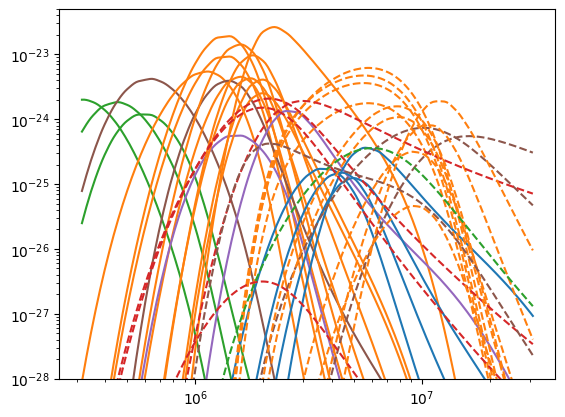

In [24]:
fig = plt.figure()
ax = fig.add_subplot()
for row in eis_lines:
    ax.plot(temperature, row['contribution function'], color=element_colors[row['element']])
for row in moxsi_lines:
    ax.plot(temperature, row['contribution function'], color=element_colors[row['element']], ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-28,5e-23)

## 3. Compute Intensities for Each Line

The calculation here is just the integration of the contribution function in temperature weighted by the emission measure distribution
Add this as a column to each table.
Also add the intensity error to each table column.
For now, just assume 20% on everything.

In [352]:
def compute_intensity(goft, goft_temperature, dem, dem_temperature):
    f_interp = interp1d(dem_temperature.to_value('K'), dem.to_value('cm-5 K-1'), fill_value='extrapolate', axis=1)
    dem_interp = f_interp(goft_temperature.to_value('K')) * u.Unit('cm-5 K-1')
    return np.trapz(dem_interp * goft, goft_temperature, axis=1).mean().to('erg cm-2 s-1')

In [353]:
error = 0.2
moxsi_lines['intensity'] = u.Quantity(
    [compute_intensity(row['contribution function'],
                       temperature,
                       #np.mean(res_single['dem_corona'], axis=0),
                       res_single['dem_corona'],
                       res_single['dem_temperature'])
     for row in moxsi_lines]
)
moxsi_lines['intensity error'] = error * moxsi_lines['intensity']
eis_lines['intensity'] = u.Quantity(
    [compute_intensity(row['contribution function'],
                       temperature,
                       #np.mean(res_single['dem_corona'], axis=0),
                       res_single['dem_corona'],
                       res_single['dem_temperature'])
     for row in eis_lines]
)
eis_lines['intensity error'] = error * eis_lines['intensity']

(5e+25, 1e+30)

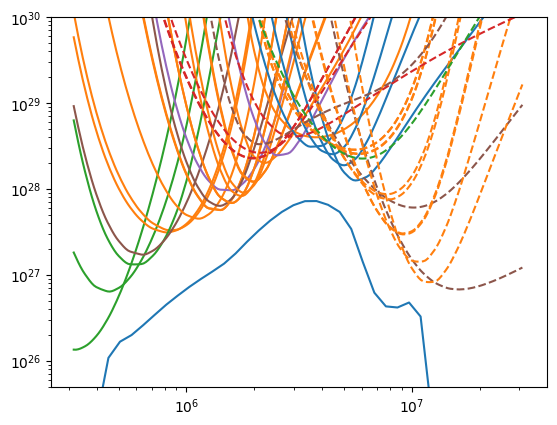

In [354]:
fig = plt.figure()
ax = fig.add_subplot()
for row in eis_lines:
    ax.plot(temperature, row['intensity']/row['contribution function'], color=element_colors[row['element']])
for row in moxsi_lines:
    ax.plot(temperature, row['intensity']/row['contribution function'], color=element_colors[row['element']], ls='--')
ax.plot(res_single['dem_temperature'], np.mean(res_single['em_corona'], axis=0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(5e25,1e30)

In [410]:
try:
    foo = astropy.table.QTable.read('foo.asdf')
except FileNotFoundError:
    print('Build the table here')

Build the table here


In [411]:
moxsi_lines.write(pathlib.Path('/Users/wtbarnes/Desktop/') / 'foo.asdf')

## 4. DEM Inversions

In [371]:
left = temp_bins.bin_centers - temp_bins.bin_widths/2
right = temp_bins.bin_centers + temp_bins.bin_widths/2

In [393]:
np.append(left,right[-1]).shape

(18,)

In [388]:
delta_logt = np.diff(np.log10(temp_bins.bin_centers.value))[0]
np.unique([np.log10(temp_bins.bin_centers.value) - delta_logt/2,
           np.log10(temp_bins.bin_centers.value) + delta_logt/2,])

array([5.5528719, 5.6528719, 5.7528719, 5.8528719, 5.9528719, 6.0528719,
       6.1528719, 6.2528719, 6.3528719, 6.4528719, 6.5528719, 6.6528719,
       6.7528719, 6.8528719, 6.9528719, 7.0528719, 7.1528719, 7.2528719])

In [391]:
np.log10(temp_bins.edges.value)

array([5.55, 5.65, 5.75, 5.85, 5.95, 6.05, 6.15, 6.25, 6.35, 6.45, 6.55,
       6.65, 6.75, 6.85, 6.95, 7.05, 7.15, 7.25])

In [355]:
from demcmc import EmissionLine, TempBins, ContFuncDiscrete, plot_emission_loci, predict_dem_emcee

In [356]:
def assess_convergence(result):
    chain = result.sampler.get_chain()
    nsamplers = chain.shape[1]
    nparams = chain.shape[2]

    fig, axs = plt.subplots(nrows=nparams, sharex=True, figsize=(6, 20))

    for ax, param in zip(axs, range(chain.shape[2])):
        for sampler in range(chain.shape[1]):
            ax.plot(chain[:, sampler, param], color="tab:blue", alpha=0.1)

        # Plot average of each walker at each step
        ax.plot(np.mean(chain[:, :, param], axis=1), color="k")

        ax.set_yscale("log")
        ax.margins(x=0)
        ax.xaxis.grid()

    fig.subplots_adjust(hspace=0)
    axs[0].set_title("Parameter estimates as a function of MCMC step")

### Inversion with only Cool Lines

In [357]:
cool_lines = []
for row in eis_lines:
    name = f"{row['ion name']}_{row['wavelength']:.3f}"
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(temperature, row['contribution function'].to_value('erg cm3 s-1')*u.Unit('cm5 K-1'), name=name),
        intensity_obs=row['intensity'].to_value('erg cm-2 s-1'),
        sigma_intensity_obs=row['intensity error'].to_value('erg cm-2 s-1'),
        name=name,
    )
    cool_lines.append(eline)

In [358]:
temp_bins = TempBins(10 ** np.arange(5.55, 7.3, 0.1) * u.K)

In [359]:
dem_result_cool_only = predict_dem_emcee(cool_lines, temp_bins, nwalkers=200, nsteps=2000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 131.27it/s]


In [361]:
temp_bins.edges

<Quantity [  354813.38923358,   446683.59215096,   562341.32519035,
             707945.78438414,   891250.93813374,  1122018.45430196,
            1412537.54462275,  1778279.41003891,  2238721.13856832,
            2818382.93126443,  3548133.89233572,  4466835.92150959,
            5623413.25190343,  7079457.8438413 ,  8912509.38133735,
           11220184.54301949, 14125375.44622735, 17782794.10038897] K>

/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


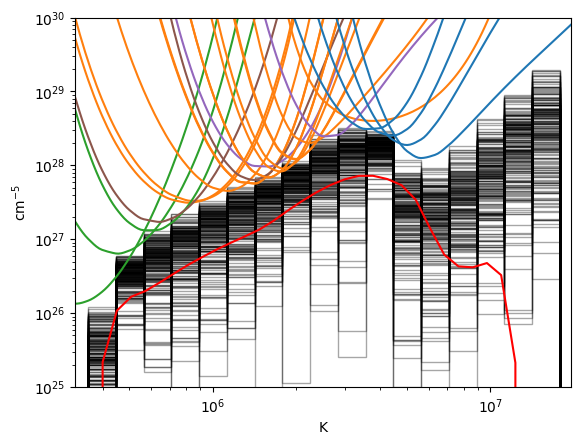

In [360]:
fig, ax = plt.subplots()

with quantity_support():

    for sample in dem_result_cool_only.samples:
        ax.stairs(sample.value*u.Unit('cm-5 K-1')*temp_bins.bin_widths, edges=temp_bins.edges, color='k', alpha=0.35)
        
    ax.plot(res_single['dem_temperature'], np.mean(res_single['em_corona'], axis=0), color='red')
    for row in eis_lines:
        ax.plot(temperature, row['intensity']/row['contribution function'], color=element_colors[row['element']])

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(temp_bins.min.to_value('K') * 0.9, temp_bins.max * 1.1)
    ax.set_ylim(1e25*u.cm**(-5),1e30*u.cm**(-5))

### Inversion with the MOXSI Lines

In [344]:
hot_lines = []
for row in moxsi_lines:
    name = f"{row['ion name']}_{row['wavelength']:.3f}"
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(temperature, row['contribution function'].to_value('erg cm3 s-1')*u.Unit('cm5 K-1'), name=name),
        intensity_obs=row['intensity'].to_value('erg cm-2 s-1'),
        sigma_intensity_obs=row['intensity error'].to_value('erg cm-2 s-1'),
        name=name,
    )
    hot_lines.append(eline)

In [345]:
dem_result_hot_only = predict_dem_emcee(hot_lines, temp_bins, nwalkers=200, nsteps=3000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 163.72it/s]


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


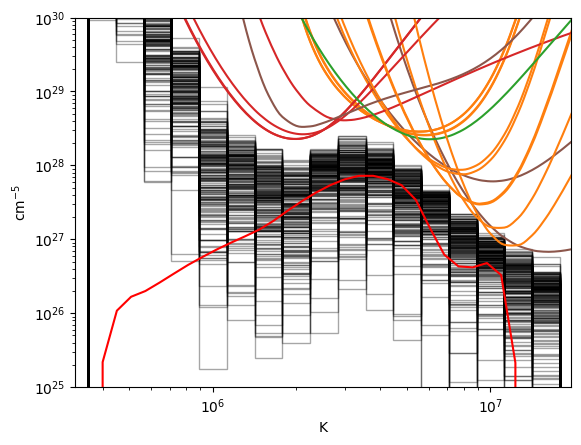

In [346]:
fig, ax = plt.subplots()

with quantity_support():

    for sample in dem_result_hot_only.samples:
        ax.stairs(sample.value*u.Unit('cm-5 K-1')*temp_bins.bin_widths, edges=temp_bins.edges, color='k', alpha=0.35)
        
    ax.plot(res_single['dem_temperature'], np.mean(res_single['em_corona'], axis=0), color='red')
    
    for row in moxsi_lines:
        ax.plot(temperature, row['intensity']/row['contribution function'], color=element_colors[row['element']])

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(temp_bins.min.to_value('K') * 0.9, temp_bins.max * 1.1)
    ax.set_ylim(1e25*u.cm**(-5),1e30*u.cm**(-5))

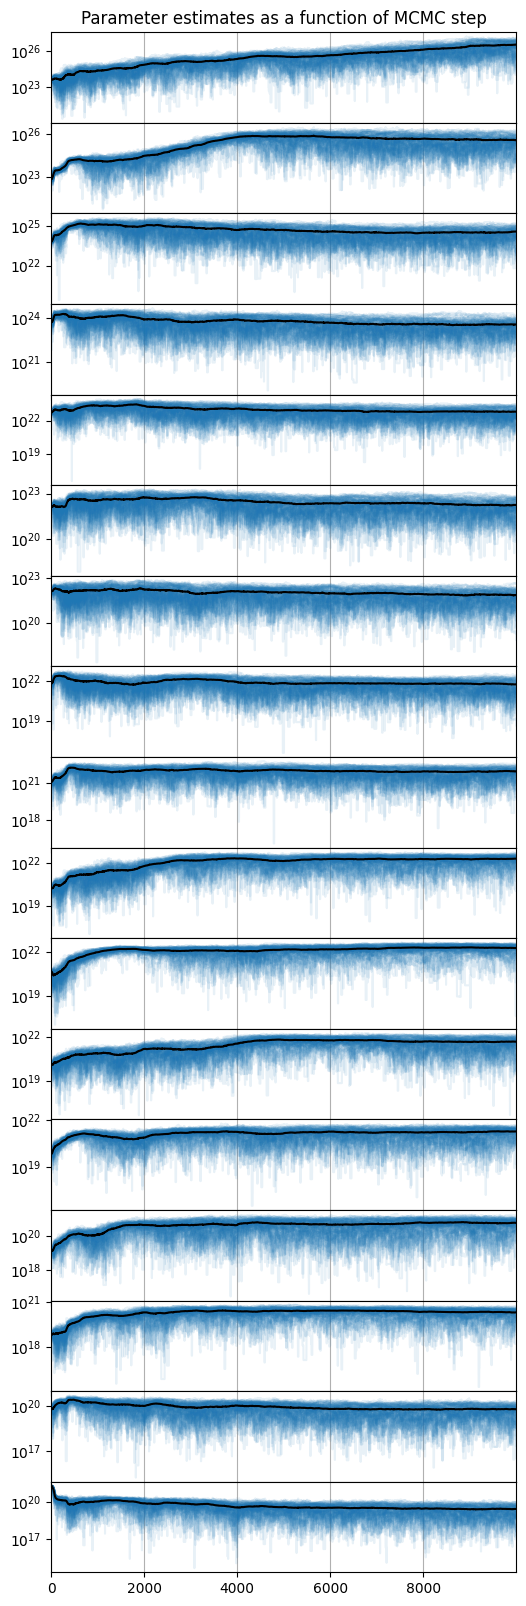

In [255]:
assess_convergence(dem_result_hot_only)

### Inversion with MOXSI+EIS Lines

In [347]:
all_lines = []
for row in astropy.table.vstack([eis_lines, moxsi_lines]):
    name = f"{row['ion name']}_{row['wavelength']:.3f}"
    eline = EmissionLine(
        cont_func=ContFuncDiscrete(temperature, row['contribution function'].to_value('erg cm3 s-1')*u.Unit('cm5 K-1'), name=name),
        intensity_obs=row['intensity'].to_value('erg cm-2 s-1'),
        sigma_intensity_obs=row['intensity error'].to_value('erg cm-2 s-1'),
        name=name,
    )
    all_lines.append(eline)

In [348]:
dem_result_all = predict_dem_emcee(all_lines, temp_bins, nwalkers=200, nsteps=2000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.84it/s]


/Users/wtbarnes/mambaforge/envs/spd-2023-moxsi-talk/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


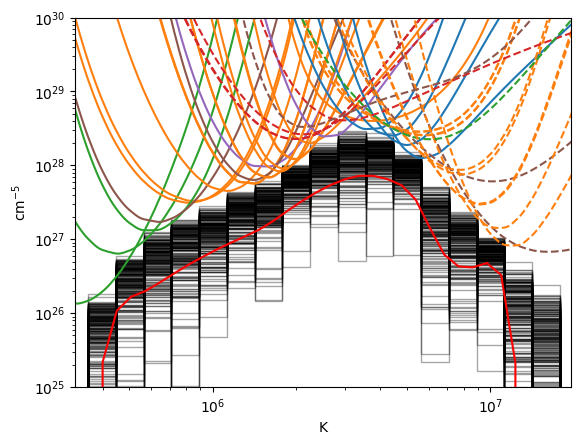

In [349]:
fig, ax = plt.subplots()

with quantity_support():

    for sample in dem_result_all.samples:
        ax.stairs(sample.value*u.Unit('cm-5 K-1')*temp_bins.bin_widths, edges=temp_bins.edges, color='k', alpha=0.35)
        
    ax.plot(res_single['dem_temperature'], np.mean(res_single['em_corona'], axis=0), color='red')
    
    for row in eis_lines:
        ax.plot(temperature, row['intensity']/row['contribution function'], color=element_colors[row['element']])
    for row in moxsi_lines:
        ax.plot(temperature, row['intensity']/row['contribution function'], color=element_colors[row['element']], ls='--')

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(temp_bins.min.to_value('K') * 0.9, temp_bins.max * 1.1)
    ax.set_ylim(1e25*u.cm**(-5),1e30*u.cm**(-5))

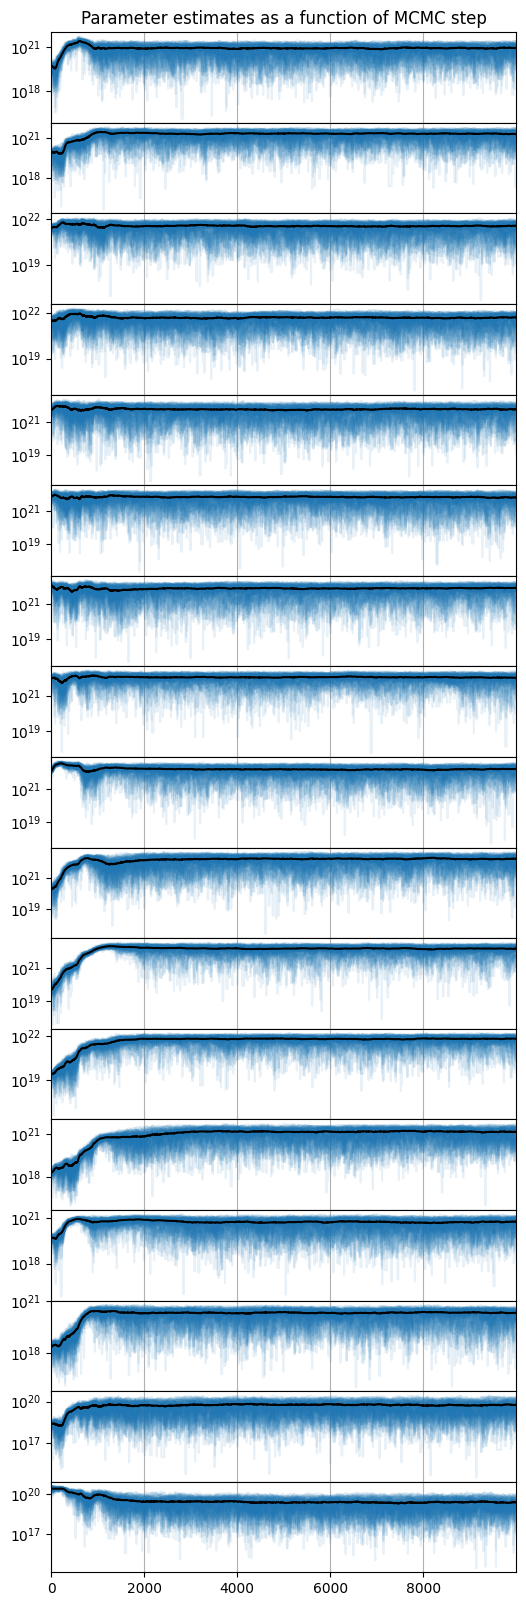

In [259]:
assess_convergence(dem_result_all)

In [412]:
foo = astropy.table.QTable.read('../data/selected_line_list.asdf')

In [415]:
np.unique(foo['element'])

Ca
Fe
Mg
O
S
Si


In [416]:
import wesanderson

In [417]:
wesanderson.color_palettes['The Grand Budapest Hotel']

[['#F1BB7B', '#FD6467', '#5B1A18', '#D67236'],
 ['#E6A0C4', '#C6CDF7', '#D8A499', '#7294D4']]

In [422]:
foo['observed by MOXSI'] == False

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])